In [167]:
from statsbombpy import sb
import mplsoccer

import pandas as pd
import numpy as np
import math
import ast
import sklearn


import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [168]:
data = pd.read_csv('D:/Football_data_scientist/data/ISL_shots.csv')
data2 = pd.read_csv('D:/Football_data_scientist/data/LaLiga_20_21_shots.csv')
data3 = pd.read_csv('D:/Football_data_scientist/data/LaLiga_19_20_shots.csv')
data4 = pd.read_csv('D:/Football_data_scientist/data/Euro_2020_shots.csv')
data5 = pd.read_csv('D:/Football_data_scientist/data/Fifa_2022_shots.csv')

In [169]:
merged_data = pd.concat([data,data2,data3,data4,data5])

In [170]:
merged_data

,Unnamed: 0,level_0,id,index,play_pattern,location,shot,type,outcome,body_part,xG_statsbomb
0,0,9,41c752ca-0121-4090-a8c1-685a10fa057e,2057,Regular Play,"[106.7, 48.5]","{'statsbomb_xg': 0.09305495, 'end_location': [...",Open Play,Off T,Right Foot,0.093055
1,1,11,a10836e8-28f3-4ab4-b250-1dec9756559b,2264,Regular Play,"[102.2, 47.3]","{'statsbomb_xg': 0.053034723, 'end_location': ...",Open Play,Saved,Right Foot,0.053035
2,2,13,eadaaccd-319b-4275-af68-47701b7c2433,2448,Regular Play,"[99.0, 51.6]","{'statsbomb_xg': 0.061114587, 'end_location': ...",Open Play,Goal,Right Foot,0.061115
3,3,17,48885ba4-54e3-4504-afd3-8941e149497b,2753,Regular Play,"[101.1, 24.4]","{'statsbomb_xg': 0.03049218, 'end_location': [...",Open Play,Saved,Right Foot,0.030492
4,4,22,c3afd07a-30a8-4130-abb4-0d52ffc4db74,3092,Regular Play,"[103.0, 51.4]","{'statsbomb_xg': 0.056751974, 'end_location': ...",Open Play,Blocked,Right Foot,0.056752
...,...,...,...,...,...,...,...,...,...,...,...
445,5,7,7a8d09b4-e1da-4112-a8fc-6784cf2029a4,2476,Regular Play,"[100.5, 55.8]","{'statsbomb_xg': 0.027777622, 'end_location': ...",Open Play,Goal,Left Foot,NaN
446,6,13,ef2acb37-fc25-440c-9a5d-88a9cffa5d48,3913,Regular Play,"[96.8, 52.1]","{'statsbomb_xg': 0.02842248, 'end_location': [...",Open Play,Blocked,Left Foot,NaN
447,0,1,e6b6a9b1-6174-4c55-98b7-dd219e256299,183,Regular Play,"[114.0, 54.8]","{'statsbomb_xg': 0.014059674, 'end_location': ...",Open Play,Blocked,Left Foot,NaN
448,1,20,a0ccad21-8e44-4a4f-ad5e-0eae6a6fcbc2,3077,Regular Play,"[102.5, 24.2]","{'statsbomb_xg': 0.02872357, 'end_location': [...",Open Play,Off T,Right Foot,NaN


In [171]:
#filter data to get only open play shots which are not headers
merged_data = merged_data[(merged_data['type']=='Open Play') & (merged_data['body_part']!='Head')]

In [172]:
#for the base model, we will use only distance from goal and angle as seen by the player
data1 = merged_data[['location','outcome']].reset_index(drop=True)

In [173]:
data1

,location,outcome
0,"[106.7, 48.5]",Off T
1,"[102.2, 47.3]",Saved
2,"[99.0, 51.6]",Goal
3,"[101.1, 24.4]",Saved
4,"[103.0, 51.4]",Blocked
...,...,...
2171,"[100.5, 55.8]",Goal
2172,"[96.8, 52.1]",Blocked
2173,"[114.0, 54.8]",Blocked
2174,"[102.5, 24.2]",Off T


In [174]:
data1['outcome'] = np.where(data1['outcome']=='Goal',1,0)

In [175]:
data1['location'] = data1.apply(lambda x : ast.literal_eval(x['location']) ,axis=1 )
data1['x'] = data1.apply(lambda x: x['location'][0],axis=1)
data1['y'] = data1.apply(lambda x: x['location'][1],axis=1)

In [176]:
data1

,location,outcome,x,y
0,"[106.7, 48.5]",0,106.7,48.5
1,"[102.2, 47.3]",0,102.2,47.3
2,"[99.0, 51.6]",1,99.0,51.6
3,"[101.1, 24.4]",0,101.1,24.4
4,"[103.0, 51.4]",0,103.0,51.4
...,...,...,...,...
2171,"[100.5, 55.8]",1,100.5,55.8
2172,"[96.8, 52.1]",0,96.8,52.1
2173,"[114.0, 54.8]",0,114.0,54.8
2174,"[102.5, 24.2]",0,102.5,24.2


In [177]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   location  2176 non-null   object 
 1   outcome   2176 non-null   int32  
 2   x         2176 non-null   float64
 3   y         2176 non-null   float64
dtypes: float64(2), int32(1), object(1)
memory usage: 59.6+ KB


In [178]:
data1.describe()

,outcome,x,y
count,2176.000000,2176.000000,2176.000000
mean,0.105699,102.512224,39.708502
std,0.307522,8.442670,10.383362
min,0.000000,56.700000,4.000000
25%,0.000000,97.100000,30.975000
50%,0.000000,103.100000,39.800000
75%,0.000000,108.800000,48.300000
max,1.000000,119.300000,79.600000


In [179]:
data1.outcome.value_counts()

0    1946
1     230
Name: outcome, dtype: int64

In [180]:
# creating the distance and angle columns
data1['distance'] = np.sqrt((120-data1['x'])**2 + (40-data1['y'])**2)
# to make sure angle is always positive we add pi where its less than 0
data1['angle'] = np.where(np.arctan((8*(120 - data1['x']))/((120- data1['x'])**2 +((40 - data1['y'])**2) - 16))>0,np.arctan((8*(120 - data1['x']))/((120- data1['x'])**2 +((40 - data1['y'])**2) - 16)), np.arctan((8*(120 - data1['x']))/((120- data1['x'])**2 +((40 - data1['y'])**2) - 16)) + np.pi)
#converting to degrees for better interpretebility
data1['angle'] = data1['angle']*180/np.pi                       

In [181]:
data1.describe()

,outcome,x,y,distance,angle
count,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000
mean,0.105699,102.512224,39.708502,20.507121,21.858680
std,0.307522,8.442670,10.383362,8.025300,12.051406
min,0.000000,56.700000,4.000000,2.596151,2.614243
25%,0.000000,97.100000,30.975000,14.973392,14.981118
50%,0.000000,103.100000,39.800000,19.973479,18.574917
75%,0.000000,108.800000,48.300000,25.389959,24.470739
max,1.000000,119.300000,79.600000,70.830784,148.836481


<AxesSubplot:xlabel='distance', ylabel='Count'>

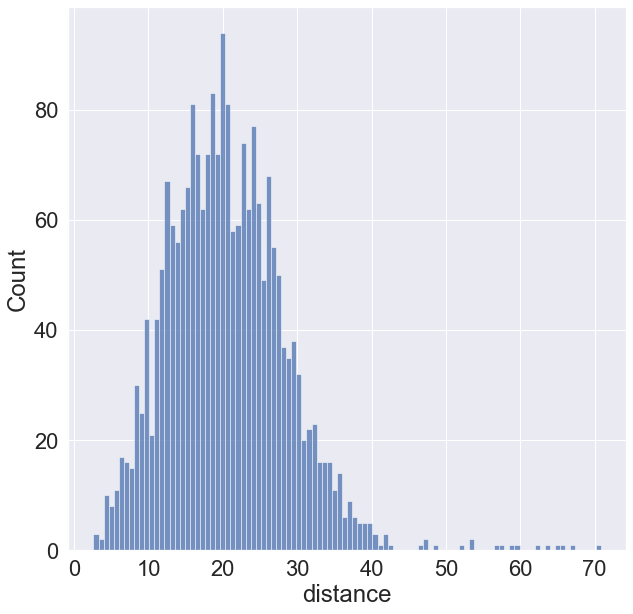

In [182]:
fig = plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.histplot(data=data1, x='distance' , bins=100 )

<AxesSubplot:xlabel='angle', ylabel='Count'>

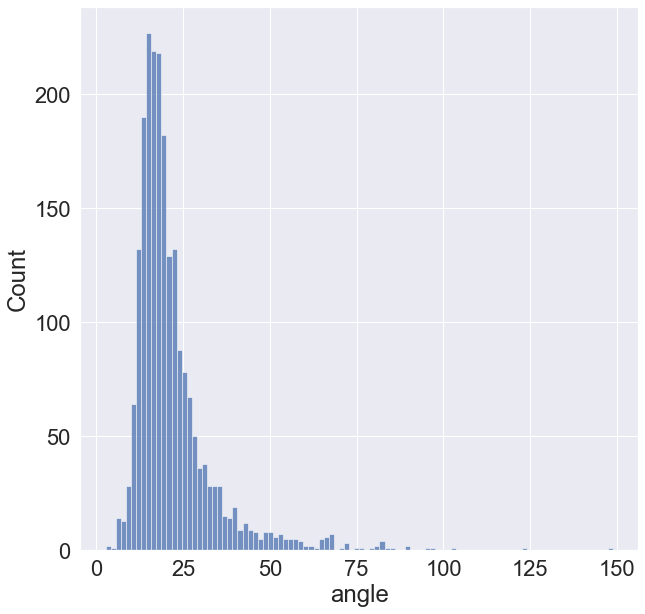

In [183]:
fig = plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.histplot(data=data1, x='angle' , bins=100 )

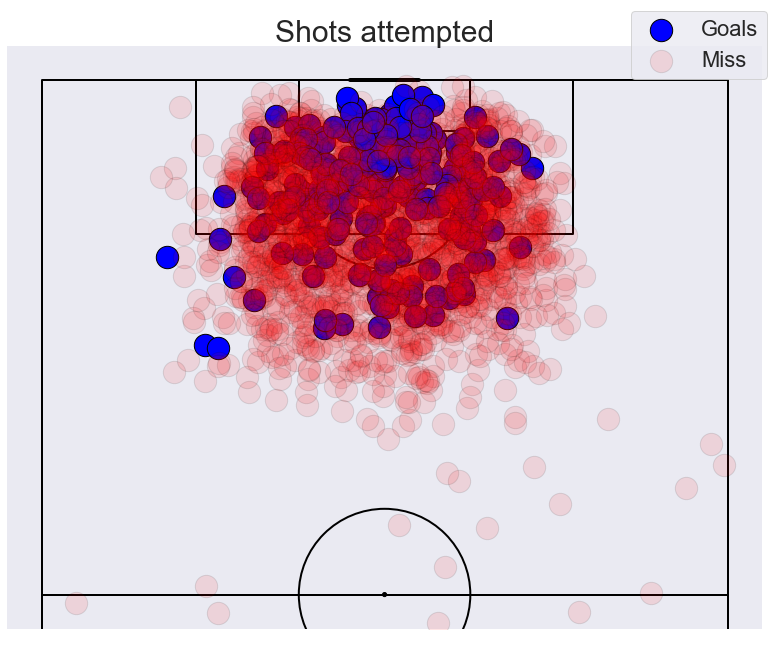

In [184]:
from mplsoccer import VerticalPitch
goals = data1[data1['outcome']==1]
shots = data1[data1['outcome']!=1]

pitch = VerticalPitch(line_color='black', half = True)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#plotting all shots
pitch.scatter(goals.x, goals.y, alpha = 1, s = 500, color = "blue", ax=ax['pitch'], edgecolors="black",label = 'Goals')
pitch.scatter(shots.x, shots.y, alpha = 0.1, s = 500, color = "red", ax=ax['pitch'], edgecolors="black",label= 'Miss')

fig.suptitle("Shots attempted", fontsize = 30)
fig.legend(loc="upper right")


plt.show()

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data1[['distance','angle']], data1['outcome'], test_size=.2,random_state=42,stratify=data1['outcome'])

In [186]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [202]:
%timeit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

params = {
        "n_estimators": [100,150,200],
        'max_depth': [3,4,5,6,7]
        }

xgb = XGBClassifier(learning_rate=0.02 , random_state=42)

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 42)

random_search = GridSearchCV(xgb, param_grid=params,  scoring='f1', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3)

random_search.fit(X_train,y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[13:28:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=<generator object _BaseKFold.split at 0x000001FB87710AC0>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,


In [203]:
print(random_search.best_score_)
print(random_search.best_params_)

0.23287771998116824
{'max_depth': 4, 'n_estimators': 100}


In [204]:
preds = random_search.predict(X_test)

In [205]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 

cm = confusion_matrix(y_test, preds) 
# Accuracy 
accuracy = accuracy_score(y_test, preds) 
# Precision 
precision = precision_score(y_test, preds) 
# Recall 
recall = recall_score(y_test, preds) 
# F1-Score 
f1 = f1_score(y_test, preds) 
# ROC Curve and AUC 
fpr, tpr, thresholds = roc_curve(y_test, preds) 
roc_auc = auc(fpr, tpr) 
  
print("Confusion Matrix:") 
print(cm) 
print("Accuracy:", accuracy) 
print("Precision:", precision) 
print("Recall:", recall) 
print("F1-Score:", f1) 
print("ROC AUC:", roc_auc) 

Confusion Matrix:
[[381   9]
 [ 37   9]]
Accuracy: 0.8944954128440367
Precision: 0.5
Recall: 0.1956521739130435
F1-Score: 0.28125
ROC AUC: 0.5862876254180601


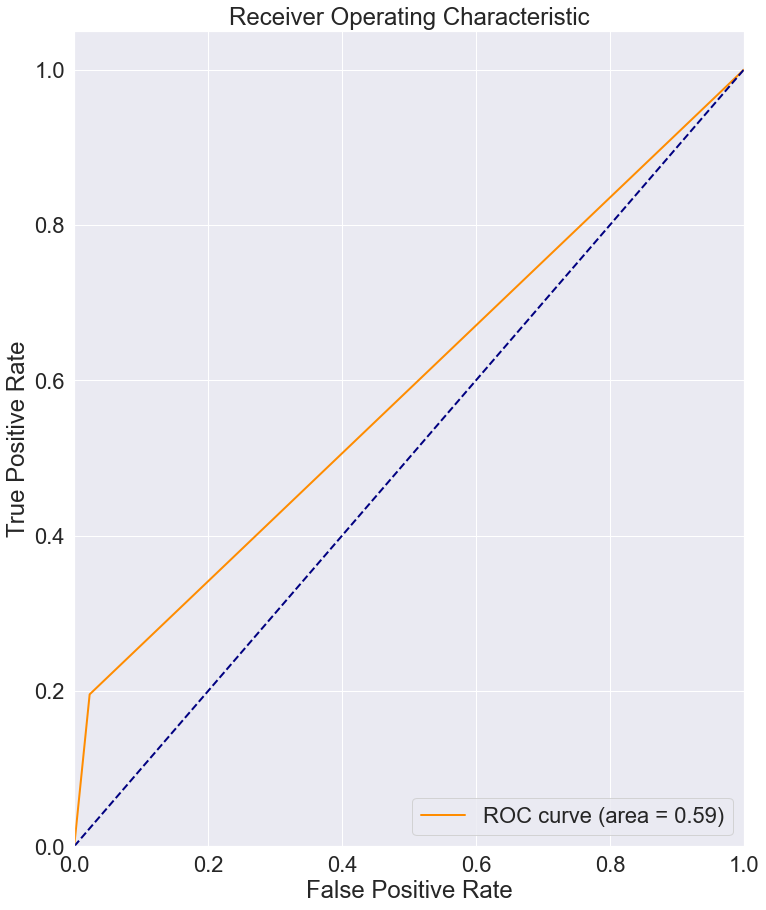

In [206]:
# Plot ROC curve 
plt.figure(figsize=(12,15)) 
  
# Plot the ROC curve with a label displaying the ROC AUC score 
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = %0.2f)' % roc_auc) 
  
# Plot a dashed diagonal line for reference 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
  
# Set the x and y-axis limits 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
  
# Label the x and y-axes 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
  
# Set the title of the plot 
plt.title('Receiver Operating Characteristic') 
  
# Add a legend to the plot 
plt.legend(loc='lower right') 
  
# Display the ROC curve plot 
plt.show()